In [1]:
import wandb
import os
import pandas as pd
import time
%matplotlib inline
import importlib
from common import common
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from concurrent.futures import ProcessPoolExecutor
from concurrent.futures import as_completed

In [2]:
wandb.login()

wandb: Currently logged in as: brinashong. Use `wandb login --relogin` to force relogin


True

In [3]:
# Reload common module
importlib.reload(common)

<module 'common.common' from '/home/brina/nus-mcomp/sem2/cs5344-big-data-analytics-technology/CS5344_Project/work/common/common.py'>

In [4]:
# Shared variables
OUTPUT_FOLDER = 'csv_files'
FEATURE_FOLDER = 'features'

In [56]:
# project name should correspond to dataset below
# project_name = "thyroid"
# project_name = "cirrhosis"
# project_name = "heart"
project_name = "hepatitis"

In [57]:
if project_name == "thyroid":
    %run datasets/thyroid.ipynb
    all_df, main_labels, config = get_processed_thyroid_df()
elif project_name == "cirrhosis":
    %run datasets/cirrhosis.ipynb
    all_df, main_labels, config = get_processed_cirrhosis_df()
elif project_name == "heart":
    %run datasets/heart.ipynb
    all_df, main_labels, config = get_processed_heart_df()
else:
    %run datasets/hepatitis.ipynb
    all_df, main_labels, config = get_processed_hepatitis_df()

Normal class:  0    0=Blood Donor
dtype: object
TARGET_DICT {0: '0=Blood Donor', 1: '0s=suspect Blood Donor', 2: '1=Hepatitis', 3: '2=Fibrosis', 4: '3=Cirrhosis'}
NORMAL_TARGET 0
main_labels Index(['Category', 'Age', 'ALB', 'ALP', 'ALT', 'AST', 'BIL', 'CHE', 'CHOL',
       'CREA', 'GGT', 'PROT', 'Sex_f', 'Sex_m'],
      dtype='object')


In [58]:
# Should already be one hot encoded and label encoded
TARGET_COLUMN = config['TARGET_COLUMN']
NORMAL_TARGET = config['NORMAL_TARGET']
TARGET_DICT = config['TARGET_DICT']
INV_TARGET_DICT = config['INV_TARGET_DICT']
NUMERICAL_COLUMNS = config['NUMERICAL_COLUMNS']
CATEGORICAL_COLUMNS = config['CATEGORICAL_COLUMNS']
ORDINAL_COLUMNS = config['ORDINAL_COLUMNS']
all_df.head()

,Category,Age,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT,Sex_f,Sex_m
0,0,32,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0,0.0,1.0
1,0,32,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5,0.0,1.0
2,0,32,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3,0.0,1.0
3,0,32,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7,0.0,1.0
4,0,32,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7,0.0,1.0


In [59]:
all_df.shape

(615, 14)

In [60]:
# Create a folder to save the CSVs
common.remove_files_from_directory(OUTPUT_FOLDER)
common.remove_files_from_directory(FEATURE_FOLDER)
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
os.makedirs(FEATURE_FOLDER, exist_ok=True)

All files in csv_files have been removed.
All files in features have been removed.


In [61]:
# Save all data as csv
all_df.to_csv('all_data.csv' ,index = False)

In [62]:
# Get X and y from all_df
X_df = all_df.drop(columns=[TARGET_COLUMN])
y_df = all_df[TARGET_COLUMN]

# Split the data into training and test sets
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_df, y_df, test_size=0.2, random_state=42)
print(X_train_df.shape, X_test_df.shape, y_train_df.shape, y_test_df.shape)

(492, 13) (123, 13) (492,) (123,)


In [63]:
# Concatenate X_train and y_train along the columns (axis=1)
X_y_train_df = pd.concat([X_train_df, y_train_df], axis=1)
X_y_train_df.head()

,Age,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT,Sex_f,Sex_m,Category
83,39,36.6,71.3,28.9,25.9,6.1,5.70,4.66,77.0,22.6,66.3,0.0,1.0,0
90,39,45.8,62.5,20.7,22.8,45.5,8.61,4.78,77.0,15.9,75.5,0.0,1.0,0
228,53,44.5,61.2,14.4,18.1,8.0,6.95,5.00,70.0,18.3,72.0,0.0,1.0,0
509,58,26.3,52.5,39.5,77.2,5.8,5.15,3.53,40.0,31.2,51.0,1.0,0.0,0
329,33,42.4,137.2,14.2,13.1,3.4,8.23,5.30,48.0,25.7,74.4,1.0,0.0,0


In [64]:
# Fit and transform the numeric columns
scaler, X_train_scaled_df = common.standardise(X_train_df, NUMERICAL_COLUMNS)

# Use the same scaler to transform X_test
scaler, X_test_scaled_df = common.standardise(X_test_df, NUMERICAL_COLUMNS, scaler=scaler)

In [65]:
X_test_scaled_df.head()

,Age,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT,Sex_f,Sex_m
248,0.795366,-2.404948,-0.110771,-0.494544,-0.497247,-0.456460,-1.214342,-0.869236,-0.299700,-0.235027,-1.786981,0.0,1.0
365,-0.835559,-1.821089,1.806551,-0.494544,-0.511494,-0.477766,-1.039287,-0.089890,-0.244928,-0.315482,0.068255,1.0,0.0
432,0.081836,0.355113,-0.839827,-0.464797,-0.246516,-0.174159,0.001587,-0.021376,-0.317958,-0.547095,0.218173,1.0,0.0
610,1.508896,-1.714933,16.510751,-0.949252,2.146832,2.057617,-1.219074,0.766535,-0.469494,14.995353,-0.643855,1.0,0.0
132,-0.325895,-1.095689,0.656158,-0.031337,-0.155341,-0.264709,0.313849,1.066283,0.028934,-0.286226,-0.737554,0.0,1.0


In [66]:
seconds = time.time()

minor_type_counts = all_df[TARGET_COLUMN].value_counts()
minor_type_dict = minor_type_counts.to_dict()
print('minor_type_dict', minor_type_dict)
target_index = all_df.columns.get_loc(TARGET_COLUMN)

# Linear method
for label, name in TARGET_DICT.items():
    if label == NORMAL_TARGET:
        continue  # Skip the normal target
    
    common.get_dataset_for_label(label, name, target_index, NORMAL_TARGET, OUTPUT_FOLDER, main_labels)

print("All datasets created successfully!")
print("Total operation time: =", time.time() - seconds, "seconds")

abnormal_type_dict {0: 533, 4: 30, 2: 24, 3: 21, 1: 7}
0s=suspect Blood Donor.csv created with 540 rows. (533 benign and 7 abnormal rows)
1=Hepatitis.csv created with 557 rows. (533 benign and 24 abnormal rows)
2=Fibrosis.csv created with 554 rows. (533 benign and 21 abnormal rows)
3=Cirrhosis.csv created with 563 rows. (533 benign and 30 abnormal rows)
All datasets created successfully!
Total operation time: = 0.003985404968261719 seconds


In [67]:
len(main_labels)

14

csv_files ['1=Hepatitis.csv', '3=Cirrhosis.csv', '0s=suspect Blood Donor.csv', '2=Fibrosis.csv']
Processing CSV file: 1=Hepatitis.csv
1=Hepatitis importance list:
1=Hepatitis 
           importance
Features            
AST         0.221422
ALP         0.210897
Age         0.125880
GGT         0.094041
ALT         0.087515
PROT        0.052467
CHE         0.050355
BIL         0.044957
CHOL        0.037291
CREA        0.033848
ALB         0.030068
Sex_f       0.006142
Sex_m       0.005115 



1=Hepatitis=["AST","ALP","Age","GGT","ALT"]


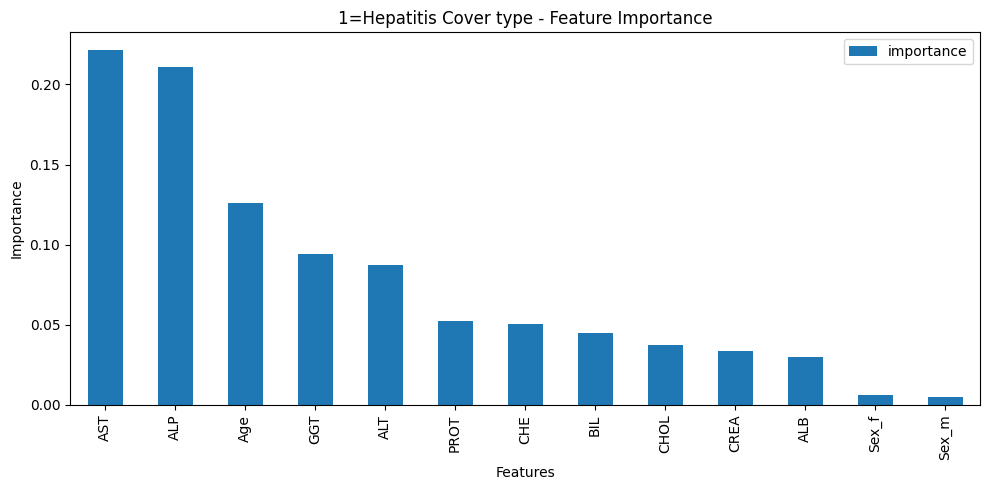

-----------------------------------------------------------------------------------------------




Processing CSV file: 3=Cirrhosis.csv
3=Cirrhosis importance list:
3=Cirrhosis 
           importance
Features            
AST         0.279210
CHE         0.234241
ALT         0.132231
GGT         0.086806
BIL         0.083746
CREA        0.055310
ALB         0.044004
CHOL        0.028881
PROT        0.019912
ALP         0.019426
Age         0.012416
Sex_m       0.002177
Sex_f       0.001642 



3=Cirrhosis=["AST","CHE","ALT","GGT","BIL"]


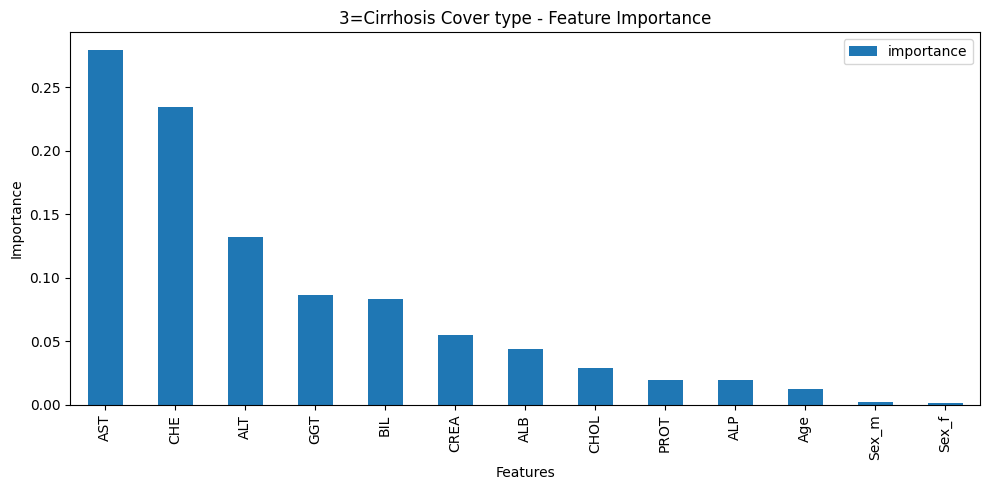

-----------------------------------------------------------------------------------------------




Processing CSV file: 0s=suspect Blood Donor.csv
0s=suspect Blood Donor importance list:
0s=suspect Blood Donor 
           importance
Features            
ALB         0.261847
PROT        0.204096
GGT         0.088949
AST         0.087188
ALT         0.087080
CHE         0.084590
CREA        0.079381
BIL         0.042058
CHOL        0.041305
ALP         0.016690
Age         0.006352
Sex_f       0.000464
Sex_m       0.000000 



0s=suspect Blood Donor=["ALB","PROT","GGT","AST","ALT"]


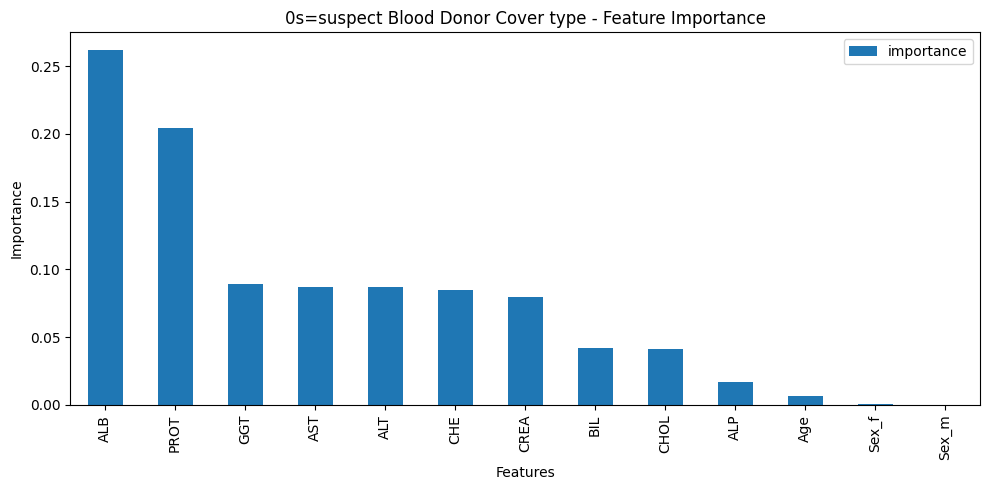

-----------------------------------------------------------------------------------------------




Processing CSV file: 2=Fibrosis.csv
2=Fibrosis importance list:
2=Fibrosis 
           importance
Features            
AST         0.331797
ALT         0.149991
GGT         0.106314
ALP         0.098793
PROT        0.075849
BIL         0.060336
CHOL        0.051240
Age         0.035035
CREA        0.033241
CHE         0.025301
ALB         0.022918
Sex_m       0.005723
Sex_f       0.003461 



2=Fibrosis=["AST","ALT","GGT","ALP","PROT"]


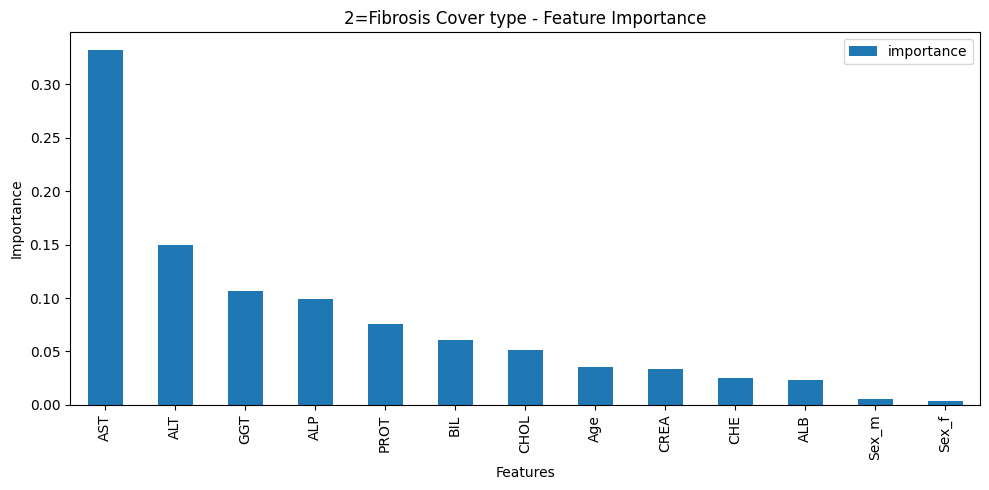

-----------------------------------------------------------------------------------------------




feature_importances: {'1=Hepatitis': ['AST', 'ALP', 'Age', 'GGT', 'ALT'], '3=Cirrhosis': ['AST', 'CHE', 'ALT', 'GGT', 'BIL'], '0s=suspect Blood Donor': ['ALB', 'PROT', 'GGT', 'AST', 'ALT'], '2=Fibrosis': ['AST', 'ALT', 'GGT', 'ALP', 'PROT']}
Total operation time: = 1.6502821445465088 seconds


In [68]:
seconds = time.time()

# CSV files names:
csv_files=os.listdir(OUTPUT_FOLDER)
print('csv_files',csv_files)

feature_importances = {}
KNNs = {}
modelname = "knn"

# Linear way
for csv in csv_files:
    label, important_features, knn, impor_bars = common.process_csv_with_args(csv, 
        main_labels=main_labels, 
        target_column=TARGET_COLUMN, 
        normal_target=NORMAL_TARGET, 
        numerical_columns=NUMERICAL_COLUMNS, 
        output_folder=OUTPUT_FOLDER,
        scaler=scaler,
        modelname=modelname)
    feature_importances[label] = important_features
    KNNs[label] = knn
    common.show_feature_importance(impor_bars, label, FEATURE_FOLDER)
    print("-----------------------------------------------------------------------------------------------\n\n\n\n")

print('feature_importances:', feature_importances)
print("Total operation time: =", time.time() - seconds, "seconds")

In [69]:
seconds = time.time()

# Define the model
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_df, y_train_df)

# Predict classes for the test set
test_predictions = rf.predict(X_test_df)
print('test_predictions', test_predictions)

print("Total operation time: = ", time.time() - seconds, "seconds")

test_predictions [0 0 0 4 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 2 0 0 0 0 4 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 4 3 0 0 3 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 3 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0]
Total operation time: =  0.16030192375183105 seconds


Multiclass Classification Evaluation


/home/brina/miniconda3/envs/gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brina/miniconda3/envs/gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brina/miniconda3/envs/gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


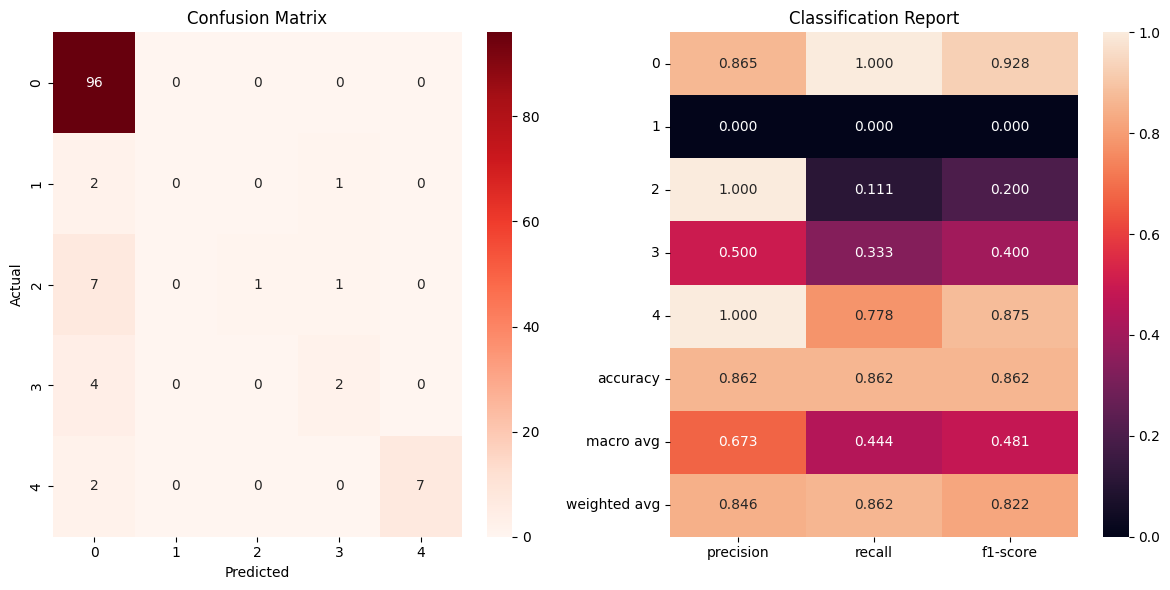

Accuracy: 0.8617886178861789


Accuracy Score,▁
f1-score_avg,▁
precision_avg,▁
recall_avg,▁
Accuracy Score,0.86179
f1-score_avg,0.8221
precision_avg,0.84575
recall_avg,0.86179


In [70]:
pn = "final-pipeline-" + project_name
wandb.init(project=pn, name="classification")
common.evaluate(y_test_df, test_predictions, heading='Multiclass Classification Evaluation')
wandb.finish()

In [71]:
seconds = time.time()
CONF_THRESHOLD = 0.95

def predict_knn(predicted_label, test_instance_df):
    selected_features = feature_importances[predicted_label]
    knn_model = KNNs[predicted_label]
    # Select features for the KNN
    test_instance_selected_df = test_instance_df[selected_features]
    knn_prediction = knn_model.predict_proba(test_instance_selected_df)
    # print(knn_prediction)
    major_class_prob = knn_prediction[:, 1]
    minor_class_prob = knn_prediction[:, 0]
    
    return (minor_class_prob, major_class_prob)
    
def process_instance(i, test_instance_df):
    if test_predictions[i] == NORMAL_TARGET:
        max_prob = CONF_THRESHOLD
        final_class_1 = NORMAL_TARGET
        final_class_2 = final_class_1

        for key, knn in KNNs.items():
            sub_minor_class_prob, sub_major_class_prob = predict_knn(key, test_instance_df)
            if sub_minor_class_prob > sub_major_class_prob and sub_minor_class_prob > max_prob:
                max_prob = sub_minor_class_prob
                final_class_2 = INV_TARGET_DICT[key]

        status = ''
        if final_class_1 != final_class_2 and final_class_2 == y_test_df.iloc[i]:
            status = 'NORMAL improve'
            print('final_class1', final_class_1, 'final_class2', final_class_2, 'actual', y_test_df.iloc[i], status, max_prob)
        if final_class_1 != final_class_2 and final_class_1 == y_test_df.iloc[i]:
            status = 'NORMAL deprove'
            print('final_class1', final_class_1, 'final_class2', final_class_2, 'actual', y_test_df.iloc[i], status, max_prob)

    else:
        predicted_label = TARGET_DICT[test_predictions[i]]
        minor_class_prob, major_class_prob = predict_knn(predicted_label, test_instance_df)
        max_prob = minor_class_prob if minor_class_prob > major_class_prob else major_class_prob
        final_class_1 = INV_TARGET_DICT[predicted_label] if minor_class_prob > major_class_prob else NORMAL_TARGET
        final_class_2 = final_class_1

        if major_class_prob > 1.0 - CONF_THRESHOLD and major_class_prob < CONF_THRESHOLD:
            for key, knn in KNNs.items():
                if key != predicted_label:
                    sub_minor_class_prob, sub_major_class_prob = predict_knn(key, test_instance_df)
                    if sub_minor_class_prob > sub_major_class_prob and sub_minor_class_prob > max_prob:
                        max_prob = sub_minor_class_prob
                        final_class_2 = INV_TARGET_DICT[key]

        status = ''
        if final_class_1 != final_class_2 and final_class_2 == y_test_df.iloc[i]:
            status = 'improve'
            print('final_class1', final_class_1, 'final_class2', final_class_2, 'actual', y_test_df.iloc[i], status, major_class_prob, max_prob)
        if final_class_1 != final_class_2 and final_class_1 == y_test_df.iloc[i]:
            status = 'deprove'
            print('final_class1', final_class_1, 'final_class2', final_class_2, 'actual', y_test_df.iloc[i], status, major_class_prob, max_prob)

    return i, final_class_2

# Run all test data instances in parallel and retain order
knn_predictions = [None] * len(X_test_scaled_df) 

with ProcessPoolExecutor() as executor:
    futures = {executor.submit(process_instance, idx, X_test_scaled_df.iloc[idx].to_frame().T): idx for idx in range(len(X_test_scaled_df))}

    for future in as_completed(futures):
        idx, prediction = future.result()
        knn_predictions[idx] = prediction 

print("Total operation time: = ", time.time() - seconds, "seconds")

final_class1 0 final_class2 2 actual 2 NORMAL improve [1.]
final_class1 0 final_class2 4 actual 4 NORMAL improve [1.]
final_class1final_class1  0 final_class10final_class2  0  2final_class2final_class2   actual12  2 actual actual NORMAL improve 12   NORMAL improve[1.]NORMAL improve 
 [1.]
[1.]
final_class1 0 final_class2 4 actual final_class14  NORMAL improve 0[1.] 
final_class2 3 final_class1 0actual final_class2 2  3actual  NORMAL improve 2 NORMAL improve [1.][1.]

final_class1 0 final_class1final_class2 0  3final_class2  actual3  3 actual  NORMAL improve3 NORMAL improve[1.] 
[1.]
final_class1 0 final_class2 1 actual 1 NORMAL improve [1.]
final_class1final_class1  0 0final_class2 final_class2  22  actualactual  22  NORMAL improveNORMAL improve  [1.]
[1.]
final_class1 0 final_class2 2 actual 2 NORMAL improve [1.]final_class1
 0 final_class2 3 actual 3 NORMAL improve [1.]
Total operation time: =  0.9470510482788086 seconds


KNN Evaluation (overall)


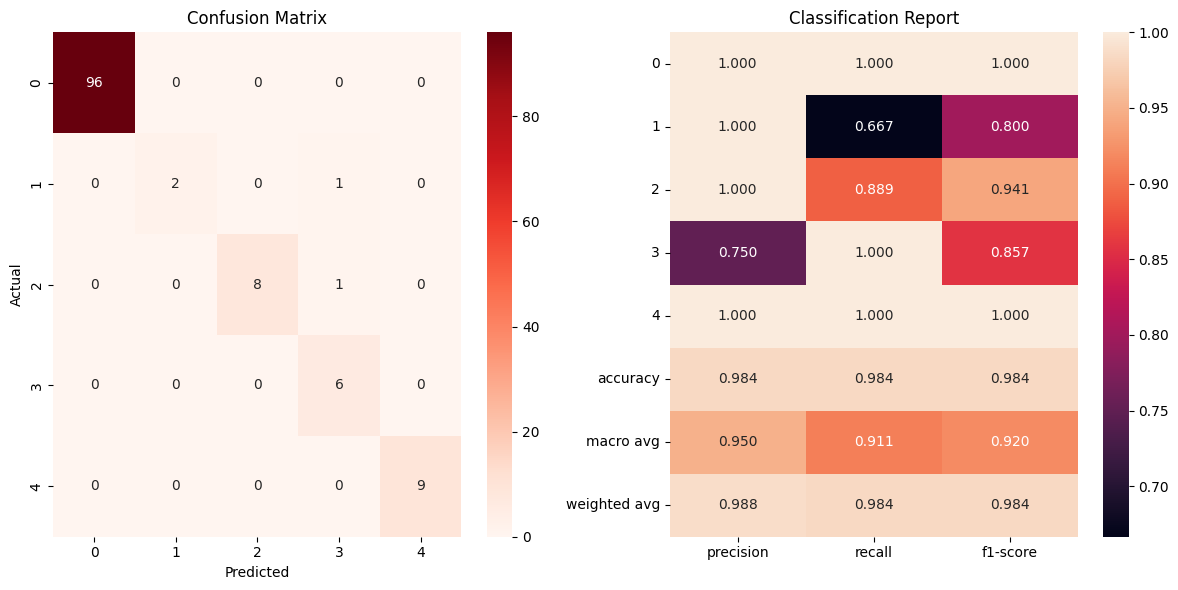

Accuracy: 0.983739837398374


Accuracy Score,▁
f1-score_avg,▁
precision_avg,▁
recall_avg,▁
Accuracy Score,0.98374
f1-score_avg,0.98385
precision_avg,0.9878
recall_avg,0.98374


In [72]:
# Evaluate KNN on all test data
pn = "final-pipeline-" + project_name
wandb.init(project=pn, name="final")

final_knn_predictions_df = pd.DataFrame(knn_predictions, columns=[TARGET_COLUMN])
common.evaluate(y_test_df, final_knn_predictions_df, heading='KNN Evaluation (overall)')
wandb.finish()